In [33]:
import pandas as pd
import numpy as np
from collections import Counter
from functools import partial
from math import log
import matplotlib as mpl
from matplotlib import pyplot as plt

import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords as sw

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from typing import Tuple
 
stop_words = set(sw.words('english')) 
# nltk.download()

pd.set_option('display.max_columns', 200)

# Read Data and Preprocess

In [2]:
filename = '../2019VAERSData/2019VAERSDATA.csv'

# rawdata = pd.read_csv(filename, header=[0], error_bad_lines=False, encoding="ISO-8859-1")
rawdata = pd.read_csv(filename, header=[0], error_bad_lines=False, encoding="latin-1")

scrub = ['\x97', '\x96', '\x91', '\x80', '\xad']
for byte in scrub:
    rawdata['SYMPTOM_TEXT'] = rawdata['SYMPTOM_TEXT'].str.replace(byte, ' ')
    
rawdata['SYMPTOM_TEXT'] = rawdata['SYMPTOM_TEXT'].str.replace('ç', 'c')

serious_bool = rawdata[['DIED', 'ER_VISIT', 'HOSPITAL', 'DISABLE']].eq('Y').any(axis=1)
rawdata['SERIOUS'] = serious_bool.map({True: 'Y', False: 'N'})

dropcols = ['DIED', 'ER_VISIT', 'HOSPITAL', 'DISABLE']
data = rawdata.drop(columns=dropcols)
data = data.set_index('VAERS_ID')

In [3]:
data.head()

,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DATEDIED,L_THREAT,HOSPDAYS,X_STAY,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,SERIOUS
VAERS_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
794156,01/01/2019,NaN,69.0,69.0,NaN,F,NaN,"Severe pain Lt. shoulder area, very localized ...",NaN,NaN,NaN,NaN,Y,10/29/2018,10/30/2018,1.0,NaN,PVT,NaN,NaN,none,none,NaN,NaN,2,01/01/2019,NaN,Y,NaN,tetracycline,N
794157,01/01/2019,IL,68.0,68.0,NaN,F,NaN,"Much joint pain/aching, lack of energy, listle...",NaN,NaN,NaN,NaN,N,12/28/2018,12/29/2018,1.0,None,PHM,NaN,"Levothyroxine, sertraline, vitamin B complex, ...",None,Hypothryoidism,Arm soreness at site of injection,NaN,2,01/01/2019,NaN,NaN,NaN,None,N
794158,01/01/2019,MA,62.0,62.0,NaN,F,NaN,"Headache, Fever, Chills, Body Aches, Nausea la...",NaN,NaN,NaN,NaN,Y,12/30/2018,12/31/2018,1.0,NaN,PHM,NaN,"Fish Oil, vitamin D, magnesium.",None,None,NaN,NaN,2,01/01/2019,NaN,NaN,NaN,None,N
794159,01/01/2019,UT,5.0,5.0,NaN,M,NaN,"Site is swollen, red and warm to the touch. Pa...",NaN,NaN,NaN,NaN,Y,12/27/2018,12/28/2018,1.0,None,PVT,NaN,Unknown,Small red spot on his cheek at time of visit.,None,NaN,NaN,2,01/01/2019,NaN,NaN,NaN,Amoxicillin,N
794160,01/01/2019,TX,79.0,79.0,NaN,F,NaN,"FLU LIKE: CHILLS ACHE ALL OVER; STRONG PAIN, W...",NaN,NaN,NaN,NaN,N,12/28/2018,12/28/2018,0.0,NONE TODAY IS A HOLIDAY,PVT,NaN,ATORVASTATIN; CELEBREX; XYZAL; D-3; ELIQUIS; A...,SINUSITIS; ATHROSCLEROSIS; DIABETES; HYPERCHOL...,SAME AS ITEM 11 ABOVE,NaN,NaN,2,01/01/2019,NaN,Y,Y,ACE INHIBITORS,N


# Process Data/Tokenize

In [4]:
# punctuation = set(""",';][=-`?><":}{+_~!@#$#%^&*()\\|}"]'""")
# punctuation.add("''")
# punctuation.add("``")


# def tokenize(text, stem=True, remove_stopwords=True, remove_punctuation=True):
#     tokens = nltk.word_tokenize(text)
    
#     if stem:
#         tokens = [PorterStemmer().stem(item) for item in tokens]
        
#     if remove_stopwords:
#         tokens = [tok for tok in tokens if tok not in stop_words]
        
#     # TAG HERE, before punctuation removal.
        
#     if remove_punctuation:
#         tokens = [tok for tok in tokens if tok not in punctuation]
        
#     return tokens

In [5]:
from nltk import word_tokenize, wordpunct_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

punctuation = set("""./,';][=-`?><":}{+_~!@#$#%^&*()\\|}"]°'×¢´""")
# punctuation.add("''")
# punctuation.add("``")

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in wordpunct_tokenize(doc) 
                if not all(char in punctuation for char in t) 
                and not all(char in '1234567890' for char in t)
                and t[0] not in '1234567890']

from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
lt = LemmaTokenizer()
lemma_stop_words = {lt.wnl.lemmatize(word) for word in stop_words}

In [7]:
vectorizer = TfidfVectorizer(tokenizer=lt, stop_words=lemma_stop_words, sublinear_tf=True)
X = vectorizer.fit_transform(rawdata['SYMPTOM_TEXT'].fillna(''))

# tfidf = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())

print(X.shape)

ind_to_token = {value: key for key, value in vectorizer.vocabulary_.items()}

(44344, 24721)


In [8]:
X_array = X.toarray()

In [9]:
X_array.shape

(44344, 24721)

In [10]:
additional_features = data[['AGE_YRS', 'SEX', 'CUR_ILL', 'PRIOR_VAX']].copy()
additional_features['AGE_YRS'] = additional_features['AGE_YRS']
additional_features['SEX'] = additional_features['SEX'].map({'F': 0, 'M': 1}).fillna(0.5)
additional_features['CUR_ILL'] = additional_features['CUR_ILL'].isna().astype(int)
additional_features['PRIOR_VAX'] = additional_features['PRIOR_VAX'].isna().astype(int)

for col in ('AGE_YRS', 'SEX'):
    additional_features[col] = additional_features[col].fillna(additional_features[col].mean())

cols = additional_features.to_numpy()

merged = np.hstack((cols, X_array))

y = data.SERIOUS

In [12]:
tree = DecisionTreeClassifier(random_state=0, 
                              min_samples_leaf=200,
                              min_samples_split=200,
                              max_depth=5)


In [13]:
tree.fit(merged, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [27]:
tree.tree_.

[Text(515.0769230769231, 498.3, 'hospitalization <= 0.012\ngini = 0.125\nsamples = 100.0%\nvalue = [0.933, 0.067]'),
 Text(386.3076923076923, 407.70000000000005, 'disabling <= 0.021\ngini = 0.098\nsamples = 98.2%\nvalue = [0.949, 0.051]'),
 Text(321.9230769230769, 317.1, 'admitted <= 0.038\ngini = 0.088\nsamples = 97.7%\nvalue = [0.954, 0.046]'),
 Text(257.53846153846155, 226.5, 'hospital <= 0.025\ngini = 0.077\nsamples = 96.8%\nvalue = [0.96, 0.04]'),
 Text(128.76923076923077, 135.89999999999998, 'life <= 0.031\ngini = 0.067\nsamples = 95.0%\nvalue = [0.965, 0.035]'),
 Text(64.38461538461539, 45.299999999999955, 'gini = 0.064\nsamples = 94.4%\nvalue = [0.967, 0.033]'),
 Text(193.15384615384616, 45.299999999999955, 'gini = 0.433\nsamples = 0.6%\nvalue = [0.683, 0.317]'),
 Text(386.3076923076923, 135.89999999999998, 'hospital <= 0.166\ngini = 0.429\nsamples = 1.8%\nvalue = [0.688, 0.312]'),
 Text(321.9230769230769, 45.299999999999955, 'gini = 0.388\nsamples = 1.3%\nvalue = [0.737, 0.263

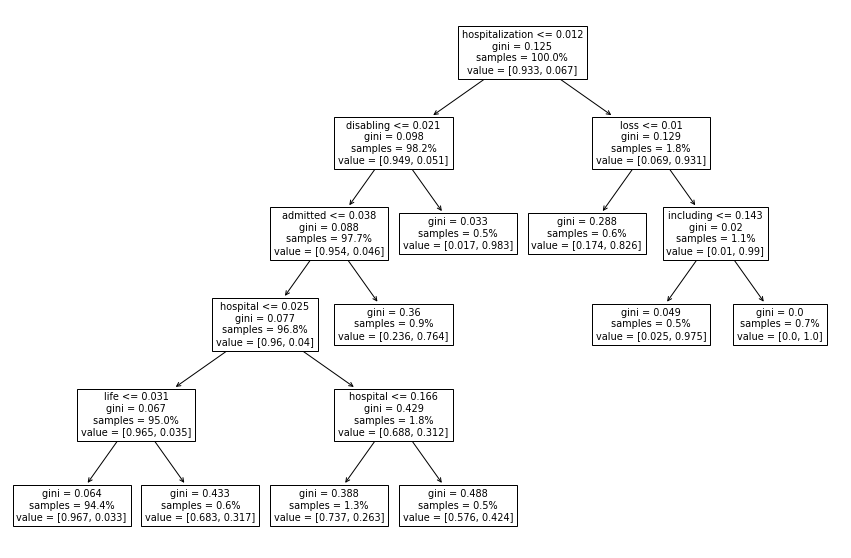

In [30]:
feats = ['AGE_YRS', 'SEX', 'CUR_ILL', 'PRIOR_VAX'] + vectorizer.get_feature_names()

fig, ax = plt.subplots(1, 1, figsize=(15,10))
plot_tree(tree, feature_names=feats, proportion=True)

[Text(515.0769230769231, 498.3, 'hospitalization <= 0.012\ngini = 0.125\nsamples = 44344\nvalue = [41366, 2978]'),
 Text(386.3076923076923, 407.70000000000005, 'disabling <= 0.021\ngini = 0.098\nsamples = 43552\nvalue = [41311, 2241]'),
 Text(321.9230769230769, 317.1, 'admitted <= 0.038\ngini = 0.088\nsamples = 43312\nvalue = [41307, 2005]'),
 Text(257.53846153846155, 226.5, 'hospital <= 0.025\ngini = 0.077\nsamples = 42930\nvalue = [41217, 1713]'),
 Text(128.76923076923077, 135.89999999999998, 'life <= 0.031\ngini = 0.067\nsamples = 42125\nvalue = [40663, 1462]'),
 Text(64.38461538461539, 45.299999999999955, 'gini = 0.064\nsamples = 41876\nvalue = [40493, 1383]'),
 Text(193.15384615384616, 45.299999999999955, 'gini = 0.433\nsamples = 249\nvalue = [170, 79]'),
 Text(386.3076923076923, 135.89999999999998, 'hospital <= 0.166\ngini = 0.429\nsamples = 805\nvalue = [554, 251]'),
 Text(321.9230769230769, 45.299999999999955, 'gini = 0.388\nsamples = 562\nvalue = [414, 148]'),
 Text(450.692307

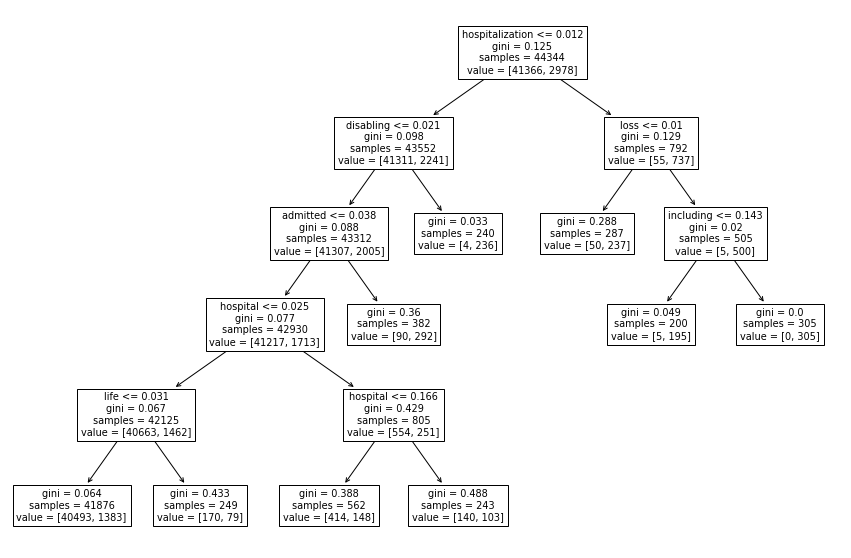

In [31]:
feats = ['AGE_YRS', 'SEX', 'CUR_ILL', 'PRIOR_VAX'] + vectorizer.get_feature_names()

fig, ax = plt.subplots(1, 1, figsize=(15,10))
plot_tree(tree, feature_names=feats, proportion=False)

In [35]:
prediction = tree.predict(merged)

In [36]:
prediction

array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype=object)

In [59]:
(prediction == "Y").sum()

1414

In [43]:
TP = ((prediction == 'Y') & (data.SERIOUS.eq("Y"))).sum()
FP = ((prediction == 'Y') & (data.SERIOUS.eq("N"))).sum()
TN = ((prediction == 'N') & (data.SERIOUS.eq("N"))).sum()
FN = ((prediction == 'N') & (data.SERIOUS.eq("Y"))).sum()

In [61]:
crosstab = pd.DataFrame(data=[{True: TP, False: FP}, {True: FN, False: TN}])
crosstab.columns.name = 'Actual'
crosstab.index = [True, False]
crosstab.index.name = 'Prediction'

crosstab

Actual,True,False
Prediction,,
True,1265,149
False,1713,41217


In [45]:
FP

149

In [46]:
TN

41217

In [47]:
FN

1713

In [20]:
feats[11128-4]

'loss'

In [21]:
feats[9523-4]

'including'

In [24]:
feats[5350-4]

'disabling'

In [11]:
# add columns age/sex/curr ill/num days to clustering
clusters = 5
model = KMeans(n_clusters=clusters, init='k-means++', max_iter=100, n_init=1)
model.fit(merged)

# tfidf['cluster'] = model.labels_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=5, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [30]:
for cluster_index in range(clusters):
    cluster = merged[(model.labels_ == cluster_index)]
#     cluster = tfidf[tfidf.cluster.eq(cluster_index)]

    tfidf = cluster[:, 5:]
    tfidf_mean = tfidf.mean(axis=0)
    tfidf_mean = np.squeeze(np.asarray(tfidf_mean))
    
    ave_age = cluster[:, 0].mean()
    male = 
    
    top_ten = tfidf_mean.argsort()[-10:][::-1]
    
    print(f"Cluster {cluster_index} (size={len(cluster)}):")
    print("-----------------------------------------")
    print(', '.join(ind_to_token[idx] for idx in top_ten))
    print()

Cluster 0 (size=14944):
-----------------------------------------
patienr, unknowingly, reportable, datasheet, receive, dosde, vaccince, medicaitons, shingritz, cascading

Cluster 1 (size=6794):
-----------------------------------------
vaccince, patienr, fetzima, givein, rarity, dawned, swellin, rednes, reactio, sitagliptin

Cluster 2 (size=6855):
-----------------------------------------
arlv, patienr, pail, injectio, dawned, sitagliptin, shingritz, swellin, rednes, rarity

Cluster 3 (size=11178):
-----------------------------------------
pail, arlv, injectio, patienr, dawned, fetzima, sitagliptin, headach, chileed, shingritz

Cluster 4 (size=4573):
-----------------------------------------
patienr, vaccince, arlv, pail, givein, injectio, sitagliptin, dawned, psychotropics, lefse



In [ ]:
cluster[:, 0].mean()

In [31]:
cluster[:, 0].mean()

21.287338727312488

In [26]:
merged[:, 0].mean()

45.967172807380685

In [28]:
cluster

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

distance measure:  

https://scikit-learn.org/stable/modules/clustering.html#k-means  
within-cluster sum-of-squares

In [314]:
data.shape

(44344, 31)

In [315]:
data['cluster'] = model.labels_

In [316]:
data.head()

,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DATEDIED,L_THREAT,HOSPDAYS,X_STAY,RECOVD,VAX_DATE,ONSET_DATE,NUMDAYS,LAB_DATA,V_ADMINBY,V_FUNDBY,OTHER_MEDS,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,SERIOUS,cluster
VAERS_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
794156,01/01/2019,NaN,69.0,69.0,NaN,F,NaN,"Severe pain Lt. shoulder area, very localized ...",NaN,NaN,NaN,NaN,Y,10/29/2018,10/30/2018,1.0,NaN,PVT,NaN,NaN,none,none,NaN,NaN,2,01/01/2019,NaN,Y,NaN,tetracycline,N,2
794157,01/01/2019,IL,68.0,68.0,NaN,F,NaN,"Much joint pain/aching, lack of energy, listle...",NaN,NaN,NaN,NaN,N,12/28/2018,12/29/2018,1.0,None,PHM,NaN,"Levothyroxine, sertraline, vitamin B complex, ...",None,Hypothryoidism,Arm soreness at site of injection,NaN,2,01/01/2019,NaN,NaN,NaN,None,N,1
794158,01/01/2019,MA,62.0,62.0,NaN,F,NaN,"Headache, Fever, Chills, Body Aches, Nausea la...",NaN,NaN,NaN,NaN,Y,12/30/2018,12/31/2018,1.0,NaN,PHM,NaN,"Fish Oil, vitamin D, magnesium.",None,None,NaN,NaN,2,01/01/2019,NaN,NaN,NaN,None,N,2
794159,01/01/2019,UT,5.0,5.0,NaN,M,NaN,"Site is swollen, red and warm to the touch. Pa...",NaN,NaN,NaN,NaN,Y,12/27/2018,12/28/2018,1.0,None,PVT,NaN,Unknown,Small red spot on his cheek at time of visit.,None,NaN,NaN,2,01/01/2019,NaN,NaN,NaN,Amoxicillin,N,1
794160,01/01/2019,TX,79.0,79.0,NaN,F,NaN,"FLU LIKE: CHILLS ACHE ALL OVER; STRONG PAIN, W...",NaN,NaN,NaN,NaN,N,12/28/2018,12/28/2018,0.0,NONE TODAY IS A HOLIDAY,PVT,NaN,ATORVASTATIN; CELEBREX; XYZAL; D-3; ELIQUIS; A...,SINUSITIS; ATHROSCLEROSIS; DIABETES; HYPERCHOL...,SAME AS ITEM 11 ABOVE,NaN,NaN,2,01/01/2019,NaN,Y,Y,ACE INHIBITORS,N,1


In [318]:
pd.crosstab(data.cluster, data.SERIOUS)

SERIOUS,N,Y
cluster,,
0,5615,127
1,5180,70
2,23078,2002
3,2692,694
4,4801,85


In [317]:
data.pivot_table(index='cluster', columns='SERIOUS')

AGE_YRS              CAGE_MO              CAGE_YR             \
SERIOUS          N          Y         N         Y          N          Y   
cluster                                                                   
0        20.800842  29.995897  0.329412  0.125000  20.980066  34.583333   
1        53.331225  42.505156  0.338415  0.350000  53.379281  43.727273   
2        45.248608  37.005634  0.320905  0.327778  45.369581  36.641509   
3        35.641392  66.529412  0.381116       NaN  34.528746  62.333333   
4        65.462022  64.638158  0.360000       NaN  65.900091  68.027027   

        FORM_VERS             HOSPDAYS    NUMDAYS              
SERIOUS         N         Y          Y          N           Y  
cluster                                                        
0        1.914337  1.960630  11.714286  43.760192  259.485714  
1        1.971622  1.642857   2.437500   8.633550   45.477612  
2        1.961478  1.864136   6.200739  21.420956   28.888430  
3        2.000000  2.000000   3.666667  70.727273  197.685185  
4        1.999792  2.000000   7.115385  12.600000    7.225806

In [269]:
vectorizer.vocabulary_['patient']

20332

In [276]:
tfidf.shape

(44344, 30822)

In [288]:
(model.labels_ == 3).argwhere(True)

AttributeError: 'numpy.ndarray' object has no attribute 'argwhere'

In [305]:
np.argwhere((model.labels_ == 1))

array([[    1],
       [    3],
       [    4],
       ...,
       [44316],
       [44325],
       [44329]])

In [311]:
rawdata.loc[44329].SYMPTOM_TEXT

'Redness and swelling at injection site - 3x2 inch area'

In [275]:
tfidf.mean(axis=0)

KeyboardInterrupt: 

In [218]:
tfidf_mean.shape

(30822,)

In [220]:
tfidf_mean.max()

0.252844294441899

In [221]:
tfidf_mean.argmax()

24680

In [222]:
tfidf_mean.argsort()[-10:][::-1]

array([24680, 20332, 28000, 20084, 22913, 23349, 10801, 23346, 12905,
        9118])

In [231]:
ind_to_word[9118]

'case'

In [211]:
c = cluster[:, 3635]

In [212]:
c.max()

0.0

In [213]:
c.min()

0.0

In [210]:
cluster.shape

(4406, 30822)

In [214]:
cluster

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.16143788, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [173]:
cluster[983]

<1x30822 sparse matrix of type '<class 'numpy.float64'>'
	with 163 stored elements in Compressed Sparse Row format>

In [139]:
sum([1 for text in rawdata['SYMPTOM_TEXT'].fillna('') if '2019434226' in text])

1

In [107]:
sum((model.labels_ == 8))

7089

In [46]:
data.loc[data.SERIOUS.eq('Y'), ['NUM_DAYS', 'SYMPTOM_TEXT', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'BIRTH_DEFECT', 'SERIOUS']].head(16)

,NUM_DAYS,SYMPTOM_TEXT,CUR_ILL,HISTORY,PRIOR_VAX,BIRTH_DEFECT,SERIOUS
VAERS_ID,,,,,,,
794190,NaN,Information has been received on 19-DEC-2018 r...,NaN,NaN,NaN,NaN,Y
794191,NaN,Information has been received on 19-DEC-2018 r...,NaN,NaN,NaN,NaN,Y
794195,NaN,"This is a literature case, initially received ...",NaN,Medical History/Concurrent Conditions: Asthma,NaN,NaN,Y
794197,NaN,As soon as I got the shots and was going to pu...,NaN,Back and neck pain Depression High blood pres...,NaN,NaN,Y
794210,NaN,"Tdap shot, tar stool, cramps in stomach, letha...",NaN,NaN,NaN,NaN,Y
794217,NaN,Vomiting started the day after the vaccine. Pa...,none,none,NaN,NaN,Y
794268,NaN,"Simple Febrile Seizure at home, lasting no mor...",None,Macrocrania- monitoring,NaN,NaN,Y
794271,NaN,Pt is complaining of left upper arm pain/shoul...,none listed,thyroid,NaN,NaN,Y
794291,NaN,Information has been received from a lawyer re...,NaN,NaN,NaN,NaN,Y


In [20]:
serious_bool.map({True: 'Y', False: 'N'})

0        N
1        N
2        N
3        N
4        N
        ..
44339    Y
44340    N
44341    N
44342    N
44343    N
Length: 44344, dtype: object